In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
import torchaudio
from ae_model import CNNAutoencoder
import matplotlib.pyplot as plt
import librosa
import soundfile as sf

from custom_audio_dataset import BirdAudioDataset

PRETRAINED_PATH = "theta_run_birds/exp/conv_autoencoder.pth"

AUDIO_FILE = "20210816T063139-0500_Rec.wav"
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device} device")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64
)

bad = BirdAudioDataset(
    AUDIO_FILE, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device
)

model = CNNAutoencoder().to(device=device)
model.load_state_dict(torch.load(PRETRAINED_PATH, map_location=torch.device("cpu")))

Using cpu device
Audio loaded!



<All keys matched successfully>

In [2]:
def plot_recons(model, device, start_frame, end_frame):

    # Load in data subset based on start_frame and end_frame
    bad_subset = Subset(bad, range(start_frame, end_frame))
    dataloader = DataLoader(bad_subset, batch_size=1)
    num_frames = end_frame - start_frame

    # Set up grayscale figure
    fig_scale = 3
    fig, axes = plt.subplots(nrows=2, ncols=num_frames, figsize=(num_frames * fig_scale, 2 * fig_scale))
    rows = ["Original", "Recon"]
    for ax, row in zip(axes[:, 0], rows):
        ax.set_ylabel(row, rotation=0, size="large")
    fig.tight_layout()
    plt.gray()
    
    # Add subplot for each original spectrogram and reconstruction
    for i, (img, index) in enumerate(dataloader):
        
        print(f"Processing sample: {i + 1}/{len(dataloader)}", end='\r')
        
        img = img.to(device)
        recon, _ = model(img)

        axes[0][i].imshow(img[0][0], cmap="plasma")
        axes[1][i].imshow(recon[0][0], cmap="plasma")
    
    print()

    # Save figure
    figure_save_path = "recon.png"
    plt.savefig(figure_save_path)
    print(f"Saved figure at path: {figure_save_path}")

In [3]:
import os
import numpy as np

def save_audio(model, device, start_frame, end_frame, frequency_cropped=False):

    time_series_imgs = np.array([])
    time_series_recons = np.array([])

    # Load in data subset based on start_frame and end_frame
    bad_subset = Subset(bad, range(start_frame, end_frame))
    dataloader = DataLoader(bad_subset, batch_size=1)
    
    audio_save_path = "sounds"
    os.makedirs(audio_save_path, exist_ok=True)
    
    # Save audio for each original spectrogram and reconstruction
    for i, (img, index) in enumerate(dataloader):
        
        print(f"Processing sample: {i + 1}/{len(dataloader)}", end='\r')
        img = img.to(device)
        recon, _ = model(img)

        if frequency_cropped:
            frequency_padding = (0, 0, 64, 0)
            img = torch.nn.functional.pad(img, frequency_padding)
            recon = torch.nn.functional.pad(recon, frequency_padding)

        time_series_img = librosa.feature.inverse.mel_to_audio(
            img[0][0].detach().numpy(), sr=SAMPLE_RATE, n_fft=1024, hop_length=512
        )
        time_series_recon = librosa.feature.inverse.mel_to_audio(
            recon[0][0].detach().numpy(), sr=SAMPLE_RATE, n_fft=1024, hop_length=512
        )

        time_series_imgs = np.concatenate((time_series_imgs, time_series_img))
        time_series_recons = np.concatenate((time_series_recons, time_series_recon))

        sf.write(f"{audio_save_path}/audio_img{i}.wav", time_series_img, SAMPLE_RATE)
        sf.write(f"{audio_save_path}/audio_recon{i}.wav", time_series_recon, SAMPLE_RATE)

    sf.write(f"{audio_save_path}/audio_img_tog.wav", time_series_imgs, SAMPLE_RATE)
    sf.write(f"{audio_save_path}/audio_recon_tog.wav", time_series_recons, SAMPLE_RATE)
        
    print()
    print(f"Saved audio files at path: {audio_save_path}")

In [4]:
def to_timestamp(index):
    return str(datetime.timedelta(seconds=index))

In [5]:
import datetime

# DEPRECATED
def get_max_loss(model, device, start_frame, end_frame):

    # Load in data subset based on start_frame and end_frame
    bad_subset = Subset(bad, range(start_frame, end_frame))
    dataloader = DataLoader(bad_subset, batch_size=1)

    avg_loss = 0
    max_loss_idx = -1
    max_loss = 0

    # Track average loss, max loss, and index of max loss
    for i, (img, index) in enumerate(dataloader):
        print(f"Processing sample: {i + 1}/{len(dataloader)}", end='\r')
        img = img.to(device)
        recon, _ = model(img)
        loss_fn = nn.MSELoss()
        loss = loss_fn(recon, img)
        if (loss.item() > max_loss):
            max_loss = loss.item()
            max_loss_idx = i
        avg_loss += loss.item()
    
    print()

    # Convert max loss index (in seconds) to a readable time (e.g. hours, minutes, seconds)
    max_loss_time = to_timestamp(max_loss_idx)

    # Compute average loss
    num_frames = end_frame - start_frame
    avg_loss /= num_frames
    
    return avg_loss, max_loss, max_loss_time

In [5]:
def get_losses(model, device, start_frame, end_frame):

    # Load in data subset based on start_frame and end_frame
    bad_subset = Subset(bad, range(start_frame, end_frame))
    dataloader = DataLoader(bad_subset, batch_size=1)

    losses = []
    timestamps = []

    # Track average loss, max loss, and index of max loss
    for i, (img, index) in enumerate(dataloader):
        print(f"Processing sample: {i + 1}/{len(dataloader)}", end='\r')
        img = img.to(device)
        recon, _ = model(img)
        loss_fn = nn.MSELoss()
        loss = loss_fn(recon, img)
        losses.append(loss.item())
        timestamps.append(to_timestamp(index.item()))
    
    print()

    return losses, timestamps

In [6]:
with torch.no_grad():
    avg_loss, max_loss, max_loss_time = get_max_loss(model, device, 0 * 60, 70 * 60)

print()
print("Average reconstruction error: ", avg_loss)
print("Maximum reconstruction error: ", max_loss)
print("Timestamp of maximum reconstruction error: ", max_loss_time)

NameError: name 'get_max_loss' is not defined

Processing sample: 4/4
Saved figure at path: recon.png


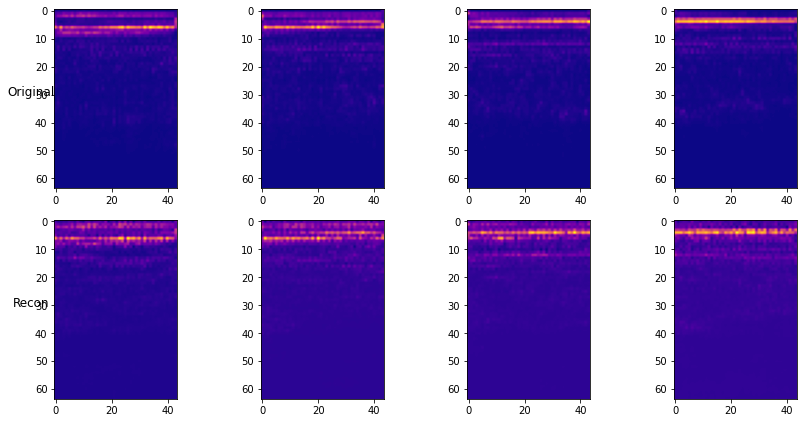

In [8]:
with torch.no_grad():
    plot_recons(model, device, (67 * 60) + 35, (67 * 60) + 39)

In [9]:
with torch.no_grad():
    save_audio(model, device, 509, 514)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Processing sample: 5/5
Saved audio files at path: sounds


In [ ]:
import datetime

def get_embeddings(model, device, start_frame, end_frame):

    # Load in data subset based on start_frame and end_frame
    bad_subset = Subset(bad, range(start_frame, end_frame))
    dataloader = DataLoader(bad_subset, batch_size=1)

    embeddings = []

    # Get embeddings
    for i, (img, index) in enumerate(dataloader):
        print(f"Processing sample: {i + 1}/{len(dataloader)}", end='\r')
        img = img.to(device)
        _, embedding = model(img)
        print(embedding)
        embeddings.append(embedding[0].detach().numpy())
    
    return embeddings

In [ ]:
# from sklearn.decomposition import PCA

# with torch.no_grad():
#     embeddings = get_embeddings(model, device, 0, len(bad))
# pca = PCA(n_components=2)
# embeddings = pca.fit_transform(embeddings)

In [15]:
with torch.no_grad():
    losses, timestamps = get_losses(model, device, 0, len(bad))
    embeddings = get_embeddings(model, device, 0, len(bad))
    losses = np.array(losses)
    timestamps = np.array(timestamps)
    embeddings = np.array(embeddings)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/functional.py:749: UserWarning:

Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.



KeyboardInterrupt: 

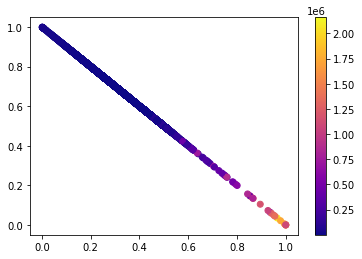

In [14]:
# import plotly.express as px
# import pandas as pd

# df = pd.DataFrame(data={'Dim. 1': embeddings[:, 0], 'Dim. 2': embeddings[:, 1], 'Loss': losses, 'Timestamp': timestamps})
# fig = px.scatter(df, x='Dim. 1', y='Dim. 2', color="Loss", hover_data=["Timestamp"])
# fig.show()

In [72]:
def get_anomalies(losses):
    for loss, timestamp in zip(losses, timestamps):
        if loss > 0.1e6:
            print(timestamp)

In [73]:
with torch.no_grad():
    get_anomalies(losses)

0:19:40
0:27:53
1:00:24
1:00:27
1:00:28
1:07:26
1:07:27
1:07:28
1:07:29
1:07:30
1:07:31
1:07:32
1:07:33
1:07:34
1:07:35
1:07:36
1:07:37
1:07:38
1:07:39
1:07:40
1:07:41
1:07:42
1:07:43
3:17:07
3:17:08
3:55:59
3:56:00
3:56:01
3:56:02
3:56:03
4:00:51
4:13:00
4:23:18
4:23:19
4:23:22
4:23:23
4:23:24
4:23:25
4:23:26
4:37:15
4:37:26
4:39:18
4:42:45
4:44:28
4:44:29
4:44:30
4:44:31
4:44:32
4:44:33
4:44:34
4:44:35
4:44:36
4:44:37
4:44:38
4:44:44
4:44:45
4:44:46
4:44:47
4:44:48
4:44:49
4:44:50
4:44:51
4:44:52
4:44:53
4:44:54
4:44:55
4:49:14
4:49:16
4:52:54
4:52:55
4:53:12
4:53:14
4:53:15
4:59:54
4:59:55
5:41:08
5:48:34
5:56:37
5:56:38
6:02:41
6:02:42
6:36:52
6:45:39
6:45:43
6:45:44
